# Topic 2: Multi-Layer Perceptron + Neuroevolution



In this notebook, we are going to introduce a basic implementation of a multi-layer perceptron. After that, we are going to catch a glimpse of a couple of neuroevolutionary examples: Algorithms which are devoted to optimizing a critical aspect of deep neural networks, their structure.


In [1]:
# We start by importing the python libraries required to solve the problems

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns

# From sklearn we will use the implementations of the Multi-layer perceptron, and the Boltzmann Machines
from sklearn import cluster
#from sklearn.datasets import fetch_mldata
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import binarize
from sklearn.neural_network import BernoulliRBM
from tensorflow.keras.datasets import mnist, fashion_mnist


# We will also use different metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder

from IPython.display import display
from IPython.display import Image

import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

We are retaking the example of the last lab to understand why we need to put multiple (activated) layers of weights on top of each other to perform certain tasks. We firstly define the liear model that we had in the last exercise of the last lab:

In [2]:
def linear_model(data):
    tf.reset_default_graph()
    
    # Two variables (x1 and x2), and one prediction (class)
    x1 = tf.placeholder("float", name="x1")
    x2 = tf.placeholder("float", name="x2")
    y = tf.placeholder("float", name="y")
    
    # One weight per variable and a final bias
    w1 = tf.Variable(0.0, name="weight1")
    w2 = tf.Variable(0.0, name="weight2")
    b = tf.Variable(0.0, name="bias")

    # Linear model
    predicted = tf.add(tf.add(tf.multiply(x1, w1), tf.multiply(x2, w2)), b)

    # Loss function
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=predicted, name="loss")

    # Optimizer & initialization
    optimizer = tf.train.AdamOptimizer(learning_rate=.001).minimize(loss)
    init = tf.global_variables_initializer()

    # Number of iterations for the learning algorithm
    training_epochs = 20000
    train_n_samples = data.shape[0]
    display_step = 4000

    mini_batch_size = 100
    n_batch = train_n_samples // mini_batch_size + (train_n_samples % mini_batch_size != 0)
    
    for i in range(data.shape[0]):
        plt.plot(data[i,0], data[i,1],'o', c=cmap[np.int(data[i,2])])
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(training_epochs):
            i_batch = (epoch % n_batch)*mini_batch_size
            batch = data[i_batch:i_batch+mini_batch_size, 0], data[i_batch:i_batch+mini_batch_size, 1], data[i_batch:i_batch+mini_batch_size, 2]
            sess.run(optimizer, feed_dict={x1: batch[0], x2: batch[1], y: batch[2]})
            if (epoch+1) % display_step == 0:
                malda, c = -sess.run(w1)/sess.run(w2), -sess.run(b)/sess.run(w2)
                plt.plot([0, 4], [c,c+malda*4], label="Epoch " + str(epoch+1))
                cost = sess.run(loss, feed_dict={x1: data[:, 0], x2: data[:, 1], y: data[:, 2]})
                print("Epoch:", str(epoch+1), "Error:", np.mean(cost))
        linear_params = [sess.run(w1), sess.run(w2), sess.run(b)]
    plt.legend()
    return linear_params

We reconstruct the DB of four clusters of points.

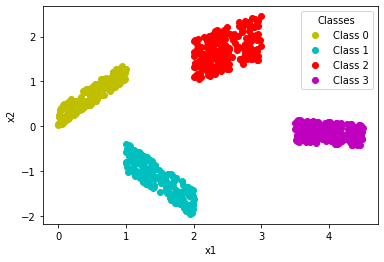

In [3]:
dlen = 200

# C1, C2, C3, and C4 contain points that when interpreted as coordinates in a 2-D grid
# correspond with very different areas in the

c1 = np.random.rand(dlen,2)
c1[:, 1] = c1[:, 0] + .42*np.random.rand(dlen)

c2 = np.random.rand(dlen,2)+1
c2[:, 1] = -c2[:, 0] + .62*np.random.rand(dlen)

c3 = np.random.rand(dlen,2)+2
c3[:, 1] = 0.5*c3[:, 0] + np.random.rand(dlen)

c4 = np.random.rand(dlen,2)+3.5
c4[:, 1] = -0.1*c4[:, 0] + 0.5*np.random.rand(dlen)


data = np.concatenate((c1, c2, c3, c4))  # We put all four clusters of points together

classes = np.array([0]*200+[1]*200+[2]*200+[3]*200).reshape((-1,1))
data_class = np.concatenate((data,classes), axis=1)  # We add the classes
cmap = ["y", "c", "r", "m"]
fig = plt.figure()
for c in np.unique(data_class[:, -1]).astype("int"):
    plt.plot(data_class[data_class[:, -1]==c,0], data_class[data_class[:, -1]==c,1], "o", label="Class " + str(c), c=cmap[c])
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend(title="Classes")


As you can see in this visualization (and we saw the other day), there is no way to separate the classes using a single line. However, two lines do:

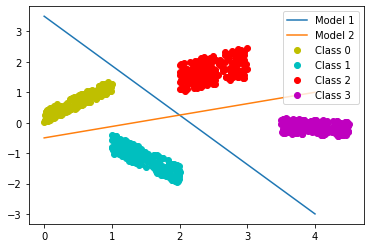

In [4]:
plt.plot([0, 4], [3.5,-3], label="Model 1")
plt.plot([0, 4], [-0.5,1], label="Model 2")
for c in np.unique(data_class[:, -1]).astype("int"):
    plt.plot(data_class[data_class[:, -1]==c,0], data_class[data_class[:, -1]==c,1], "o", label="Class " + str(c), c=cmap[c])
plt.legend()


To obtain these two lines, we need to do two adequate questions. To obtain the parameters of a model that is able to separate the data as the blue lines does, we can try to solve the following problem:

In [5]:
binary_classes1 = np.array([0]*400+[1]*400).reshape((-1,1))
data_binary1 = np.concatenate((data,binary_classes1), axis=1)

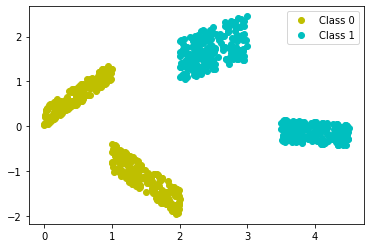

In [6]:
for c in np.unique(data_binary1[:, -1]).astype("int"):
    plt.plot(data_binary1[data_binary1[:, -1]==c,0], data_binary1[data_binary1[:, -1]==c,1], "o", label="Class " + str(c), c=cmap[c])
plt.legend()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch: 4000 Error: 0.30417073
Epoch: 8000 Error: 0.16492754
Epoch: 12000 Error: 0.093698576
Epoch: 16000 Error: 0.056189038
Epoch: 20000 Error: 0.03555459
Model parameters: [2.7632453, 1.7281953, -5.9104543]


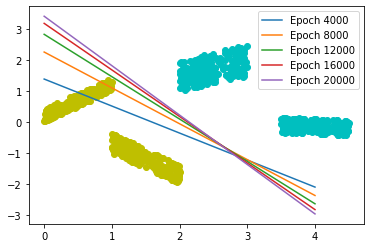

In [7]:
params1 = linear_model(data_binary1)
print("Model parameters:", params1)

Next, we can define the complementary problem:

In [8]:
binary_classes2 = np.array([0]*200+[1]*200+[0]*200+[1]*200).reshape((-1,1))
data_binary2 = np.concatenate((data,binary_classes2), axis=1)

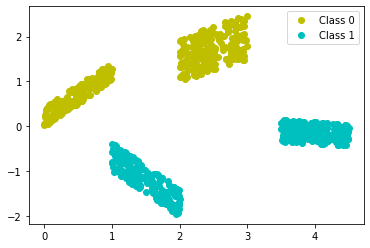

In [9]:
for c in np.unique(data_binary2[:, -1]).astype("int"):
    plt.plot(data_binary2[data_binary2[:, -1]==c,0], data_binary2[data_binary2[:, -1]==c,1], "o", label="Class " + str(c), c=cmap[c])
plt.legend()

Epoch: 4000 Error: 0.10391626
Epoch: 8000 Error: 0.027286472
Epoch: 12000 Error: 0.007908997
Epoch: 16000 Error: 0.0024304893
Epoch: 20000 Error: 0.0007868733
Model parameters: [3.2047644, -9.503693, -3.2438478]


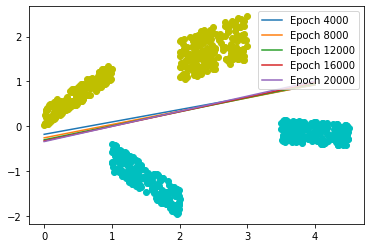

In [10]:
params2 = linear_model(data_binary2)
print("Model parameters:", params2)

Now, if we draw both lines at the same time

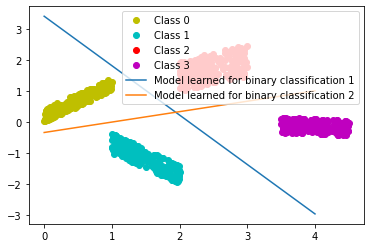

In [11]:
for c in np.unique(data_class[:, -1]).astype("int"):
    plt.plot(data_class[data_class[:, -1]==c,0], data_class[data_class[:, -1]==c,1], "o", label="Class " + str(c), c=cmap[c])
plt.plot([0, 4], [-params1[2]/params1[1],-params1[2]/params1[1]-params1[0]/params1[1]*4], label="Model learned for binary classification 1")
plt.plot([0, 4], [-params2[2]/params2[1],-params2[2]/params2[1]-params2[0]/params2[1]*4], label="Model learned for binary classification 2")

plt.legend()

Now we can define a function like this one:

In [12]:
def four_class_decision(example, model1_params, model2_params):
    prediction1 = model1_params[0]*example[0] + model1_params[1]*example[1] + model1_params[2]
    prediction2 = model2_params[0]*example[0] + model2_params[1]*example[1] + model2_params[2]
    prediction = int(prediction1>0) * 2 + int(prediction2>0)
    return prediction

And we observe that the predictions are accurate.

In [13]:
prediction = [four_class_decision(example, params1, params2) for example in data_class[:, :2]]

In [14]:
print(prediction)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [15]:
(prediction == data_class[:, 2]).all()

True

Because the function is critical to the correct prediction of the classes, it can be said that it is part of the model.

Now that we know that two linear models can correctly classify the dataset, we can define a model that comprises all the operations, and this way we do not have to define two complementary problems (with two separate loss functions) as support for the general model.

In [16]:
def double_linear_model(data):
    tf.reset_default_graph()

    x1 = tf.placeholder("float", name="x1")
    x2 = tf.placeholder("float", name="x2")
    y = tf.placeholder("float", name="y")

    w11 = tf.Variable(0.0, name="weight1_model1")
    w21 = tf.Variable(0.0, name="weight2_model1")
    b1 = tf.Variable(0.0, name="bias_model1")
    
    w12 = tf.Variable(0.0, name="weight1_model2")
    w22 = tf.Variable(0.0, name="weight2_model2")
    b2 = tf.Variable(0.0, name="bias_model2")

    model1 = tf.sigmoid(tf.add(tf.add(tf.multiply(x1, w11), tf.multiply(x2, w21)), b1))
    model2 = tf.sigmoid(tf.add(tf.add(tf.multiply(x1, w12), tf.multiply(x2, w22)), b2))
    
    combined = tf.multiply(model1, 2.) + model2

    loss = tf.losses.mean_squared_error(y, combined)

    optimizer = tf.train.AdamOptimizer(learning_rate=.001).minimize(loss)

    init = tf.global_variables_initializer()

    training_epochs = 40000
    train_n_samples = data.shape[0]
    display_step = 10000

    mini_batch_size = 100
    n_batch = train_n_samples // mini_batch_size + (train_n_samples % mini_batch_size != 0)
    
    for i in range(data.shape[0]):
        plt.plot(data[i,0], data[i,1],'o', c=cmap[np.int(data[i,2])])
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(training_epochs):
            i_batch = (epoch % n_batch)*mini_batch_size
            batch = data[i_batch:i_batch+mini_batch_size, 0], data[i_batch:i_batch+mini_batch_size, 1], data[i_batch:i_batch+mini_batch_size, 2]
            sess.run(optimizer, feed_dict={x1: batch[0], x2: batch[1], y: batch[2]})
            if (epoch+1) % display_step == 0:
                malda1, c1 = -sess.run(w11)/sess.run(w21), -sess.run(b1)/sess.run(w21)
                malda2, c2 = -sess.run(w12)/sess.run(w22), -sess.run(b2)/sess.run(w22)
                plt.plot([0, 4], [c1,c1+malda1*4], label="Model1, Epoch " + str(epoch+1))
                plt.plot([0, 4], [c2,c2+malda2*4], label="Model2, Epoch " + str(epoch+1))
                cost = sess.run(loss, feed_dict={x1: data[:, 0], x2: data[:, 1], y: data[:, 2]})
                print("Epoch:", str(epoch+1), "Error:", np.mean(cost))
        params = [sess.run(w11), sess.run(w21), sess.run(b1), sess.run(w12), sess.run(w22), sess.run(b2)]
    plt.legend()
    plt.ylim((-3.2,3.2))
    plt.xlim((-0.2,4.2))
    return params

Epoch: 10000 Error: 0.09227024
Epoch: 20000 Error: 0.07457228
Epoch: 30000 Error: 0.06594573


KeyboardInterrupt: 

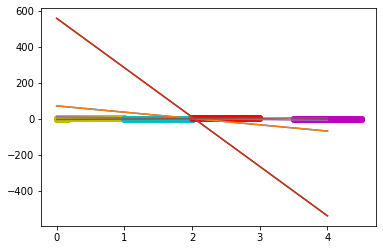

In [17]:
params = double_linear_model(data_class)

Although the operations are not the same (applying the sigmoid is not the same as comparing the value to 0, and MSE is not an adequate metric for the problem), we can observe that the model was able to learn how to correcly classify the instances in the DB without any middle step in the learning phase.

In [ ]:
prediction = np.array([four_class_decision(example, params[:3], params[3:]) for example in data_class[:, :2]])

In [ ]:
prediction

In [ ]:
(prediction == data_class[:, 2]).all()

Nevertheless, in that example, we are exploiting some knowledge we have about the problem in the sense that we combine the two models with a specific equation that suits the problem:

| Submodel1 | Submodel2 | Final prediction |
| :-: | :-: | :-: |
| 0 | 0 | 0 |
| 0 | 1 | 1 |
| 1 | 0 | 2 |
| 1 | 1 | 3 |


Which is a little bit of cheating. Moreover, if the classes had any other distribution, we should define a new model to that particular data:

| Submodel1 | Submodel2 | Possible output 1 | Possible output 2 |
| :-: | :-: | :-: | :-: |
| 0 | 0 | 0 | 0 |
| 0 | 1 | 1 | 1 |
| 1 | 0 | 2 | 1 |
| 1 | 1 | 0 | 0 |


However, having a third model that learns these last step correspondences would not be difficult. This is, a third submodel that takes the two predictions by the previous 2 submodels and learns to do the work of the equation we defined by hand:

In [ ]:
def double_layer_model(data):
    tf.reset_default_graph()
    
    # Two variables (x1 and x2), and one prediction (class)
    x1 = tf.placeholder("float", name="x1")
    x2 = tf.placeholder("float", name="x2")
    y = tf.placeholder("float", name="y")
    
    # Weights and bias for the first neuron
    w11 = tf.Variable(0.0, name="weight1_model1")
    w21 = tf.Variable(0.0, name="weight2_model1")
    b1 = tf.Variable(0.0, name="bias_model1")
    
    # Weights and bias for the second neuron
    w12 = tf.Variable(0.0, name="weight1_model2")
    w22 = tf.Variable(0.0, name="weight2_model2")
    b2 = tf.Variable(0.0, name="bias_model2")

    # Weights and bias for the two previous neurons
    w13 = tf.Variable(0.0, name="weight1_model3")
    w23 = tf.Variable(0.0, name="weight2_model3")
    b3 = tf.Variable(0.0, name="bias_model3")

    # First neuron model
    model1 = tf.sigmoid(tf.add(tf.add(tf.multiply(x1, w11), tf.multiply(x2, w21)), b1))
    # Second neuron model
    model2 = tf.sigmoid(tf.add(tf.add(tf.multiply(x1, w12), tf.multiply(x2, w22)), b2))
    # Final prediction based on the two previous neurons
    combined = tf.add(tf.add(tf.multiply(model1, w13), tf.multiply(model2, w23)), b3)

    # Loss function
    loss = tf.losses.mean_squared_error(y, combined)

    # Optimizer & initialization
    optimizer = tf.train.AdamOptimizer(learning_rate=.001).minimize(loss)
    init = tf.global_variables_initializer()

    # Number of iterations for the learning algorithm
    training_epochs = 60000
    train_n_samples = data.shape[0]
    display_step = 15000

    mini_batch_size = 100
    n_batch = train_n_samples // mini_batch_size + (train_n_samples % mini_batch_size != 0)
    
    for i in range(data.shape[0]):
        plt.plot(data[i,0], data[i,1],'o', c=cmap[np.int(data[i,2])])
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(training_epochs):
            i_batch = (epoch % n_batch)*mini_batch_size
            batch = data[i_batch:i_batch+mini_batch_size, 0], data[i_batch:i_batch+mini_batch_size, 1], data[i_batch:i_batch+mini_batch_size, 2]
            sess.run(optimizer, feed_dict={x1: batch[0], x2: batch[1], y: batch[2]})
            if (epoch+1) % display_step == 0:
                malda1, c1 = -sess.run(w11)/sess.run(w21), -sess.run(b1)/sess.run(w21)
                malda2, c2 = -sess.run(w12)/sess.run(w22), -sess.run(b2)/sess.run(w22)
                plt.plot([0, 4], [c1,c1+malda1*4], label="Model1, Epoch " + str(epoch+1))
                plt.plot([0, 4], [c2,c2+malda2*4], label="Model2, Epoch " + str(epoch+1))
                cost = sess.run(loss, feed_dict={x1: data[:, 0], x2: data[:, 1], y: data[:, 2]})
                print("Epoch:", str(epoch+1), "Error:", np.mean(cost))
        params = [sess.run(w11), sess.run(w21), sess.run(b1), sess.run(w12), sess.run(w22), sess.run(b2), sess.run(w13), sess.run(w23), sess.run(b3)]
        preds = sess.run(combined, feed_dict={x1: data[:, 0], x2: data[:, 1]})
    plt.legend()
    plt.ylim((-3.2,3.2))
    plt.xlim((-0.2,4.2))
    return params, np.round(preds)

In [ ]:
params_2layer, preds = double_layer_model(data_class)

Although the error is pretty low, apparently, the model has not learned anything, as the lines drawn usign the parameters are barely able to differentiate between sets of two clusters. However, if we take a look at the predictions

In [ ]:
preds

They are mostly correct. What happened?

We constructed a 1-hidden-layer MLP. These models are very powerful, but mostly lack the possibility of expressing anything with their parameters

In [ ]:
Image(filename='images/MLP_Networks_Parameters.png')

## Exercise 1

Now that we know how to define neural models with more than one layer, let's do it for a more complex problem, the MNIST problem. 

In the previous example, we only had two variables, so defining individual parameters by hand was easy. However, as this problem has 784 variables, this task is not feasible any more. Therefore, we will have to define matrices of weights. For this, you can take a look at the tensorflow docs or Exercise 3 of Lab 5, where we did something similar.

Additionally, because this is a multiclass problem, we are going to need one neuron in the final layer per class in the database, so that each neuron represents the probability of the example in the input belonging to a certaing class.

The hidden layer has 100 neurons.

In [ ]:
(x_mnist_tr, y_mnist_tr), (x_mnist_ts, y_mnist_ts) = mnist.load_data()

ohe = OneHotEncoder()

x_mnist_tr = np.reshape(x_mnist_tr, (-1, 784))
x_mnist_ts = np.reshape(x_mnist_ts, (-1, 784))

x_mnist_tr = x_mnist_tr/255.
x_mnist_ts = x_mnist_ts/255.

# One hot encoding
n_classes = np.unique(y_mnist_tr).shape[0]
y_mnist_tr_oh = np.eye(n_classes)[y_mnist_tr]
y_mnist_ts_oh = np.eye(n_classes)[y_mnist_ts]

In [ ]:
def MLP(data, classes, test_data, test_classes):
    tf.reset_default_graph()
    
    # One placeholder for all features (as a matrix) and another for the prediction
    x = tf.placeholder(tf.float32, [None, 784])
    y = tf.placeholder(tf.float32, [None, 10])
    
    # First layer: one matrix of weights (on top of the known features) and a vector of biases
    w1 = tf.Variable(tf.zeros([784, 100]), name="layer1_weights")
    b1 = tf.Variable(tf.zeros([100]), name="layer1_biases")
    
    # Second layer: one matrix of weights (on top of the abstract features) and a vector of biases
    w2 = tf.Variable(tf.zeros([100, 10]), name="layer2_weights")
    b2 = tf.Variable(tf.zeros([10]), name="layer2_biases")

    # First layer and probability prediction
    layer1 = tf.sigmoid(tf.add(tf.matmul(x, w1), b1))
    prediction = tf.add(tf.matmul(layer1, w2), b2)

    # Loss and class prediction
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=prediction)
    class_pred = tf.argmax(prediction, axis=1)

    # Optimizer & initialization
    optimizer = tf.train.AdamOptimizer(learning_rate=.001).minimize(loss)
    init = tf.global_variables_initializer()

    training_epochs = 10000
    train_n_samples = data.shape[0]
    display_step = 200

    mini_batch_size = 100
    n_batch = train_n_samples // mini_batch_size + (train_n_samples % mini_batch_size != 0)
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(training_epochs):
            i_batch = (epoch % n_batch)*mini_batch_size
            batch = data[i_batch:i_batch+mini_batch_size], classes[i_batch:i_batch+mini_batch_size]
            sess.run(optimizer, feed_dict={x: batch[0], y: batch[1]})
            if (epoch+1) % display_step == 0:
                cost = sess.run(loss, feed_dict={x: batch[0], y: batch[1]})
                acc = np.sum(np.argmax(test_classes, axis=1) == sess.run(class_pred, feed_dict={x: test_data}))/test_classes.shape[0]
                print("Epoch:", str(epoch+1), "Error:", np.mean(cost), "Accuracy:", acc)
        parameters = sess.run([w1, b1, w2, b2])
        test_predictions = sess.run(class_pred, feed_dict={x: test_data})
    return parameters, test_predictions

In [ ]:
params, test_preds = MLP(x_mnist_tr, y_mnist_tr_oh, x_mnist_ts, y_mnist_ts_oh)

Taking into account that this is a 10-class problem, and that we are using a very simple MLP, a ~.5 accuracy is not that bad. Let's analyze the confusion matrix:

In [ ]:
metrics.confusion_matrix(y_mnist_ts, test_preds, labels=range(10), sample_weight=None)

Although these models are not interpretable in general, sometimes visualizing the weights can give you an idea about what is being learnt in each neuron (not in this case, but have this idea and the following function in mind for future applications).

In [ ]:
def visualize_coefs(coefs):
    """
    clf must be the instanced (and trained) classifier
    """
    fig, axes = plt.subplots(10, 10, sharex=True, sharey=True)
    plt.subplots_adjust(wspace=-0.83, hspace=0)
    # use global min / max to ensure all weights are shown on the same scale
    for coef, ax in zip(coefs.T, axes.ravel()):
        ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmax=np.max(coefs), vmin=np.min(coefs))
        ax.set_xticks(())
        ax.set_yticks(())

    plt.show()

In [ ]:
visualize_coefs(params[0])

# Network structure

Successful DNN training depends on several factors. The gradient descent algorithm, the learning rate, the batch size, the initial values of the parameters... but one of the most important components is the architecture of the model. It is theorized that the deeper a DNN, the better the extraction of features is performed from the data, which ultimately results in a better classification model.

## Exercise 2

Knowing about the importance of the DNN structure, define a function that takes a list of numbers as a parameter, each of these numbers specifying the number of neurons in a layer.

- See the following cell to get an idea of what this parameter looks like

In [ ]:
def custom_MLP(data, classes, test_data, test_classes, layer_sizes):
    tf.reset_default_graph()

    x = tf.placeholder(tf.float32, [None, 784])
    y = tf.placeholder(tf.float32, [None, 10])
    # At the end of the loop, this variable should contain all the weight variables
    weights = []
    # At the end of the loop, this variable should contain all the biases variables
    biases = []
    # At the end of the loop, this variable should contain all the layers variables (the first one is the data itself)
    layers = [x]
    
    # We advise the usage of an auxiliary variable that contains the number of neurons in the last layer
    # It should initialized as the number of features in the data
    last_layer = ___
    
    # For giving names to the variables, you can use something like name="layer" + str(len(layers)) + "_{biases|weights}"
    for layer, neurons in enumerate(layer_sizes):  # For each layer specified in the list
        # "+": Concatenation between two lists
        weights = weights + [___]
        biases = biases + [___]
        layers += [tf.sigmoid(___)]
        # Update the number of neurons in the last layer
        last_layer = ___
        
    # Once we have built the DNN structure, we create the last layer, where the results will be collected
    weights = weights + [___]
    biases = biases +[___]                                                 
    prediction = ___

    loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=prediction)
    class_pred = tf.argmax(prediction, axis=1)

    optimizer = tf.train.AdamOptimizer(learning_rate=.001).minimize(loss)

    init = tf.global_variables_initializer()

    training_epochs = 10000
    train_n_samples = data.shape[0]
    display_step = 2000

    mini_batch_size = 100
    n_batch = train_n_samples // mini_batch_size + (train_n_samples % mini_batch_size != 0)
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(training_epochs):
            i_batch = (epoch % n_batch)*mini_batch_size
            batch = data[i_batch:i_batch+mini_batch_size, :], classes[i_batch:i_batch+mini_batch_size, :]
            sess.run(optimizer, feed_dict={x: batch[0], y: batch[1]})
            if (epoch+1) % display_step == 0:
                cost = sess.run(loss, feed_dict={x: batch[0], y: batch[1]})
                acc = np.sum(np.argmax(test_classes, axis=1) == sess.run(class_pred, feed_dict={x: test_data}))/test_classes.shape[0]
                print("Epoch:", str(epoch+1), "Error:", np.mean(cost), "Accuracy:", acc)
        parameters = sess.run(weights+biases)
        test_predictions = sess.run(class_pred, feed_dict={x: test_data})
    return parameters, test_predictions, acc

In [ ]:
max_layers = 10
for i in range(2, max_layers):
    layers = np.arange(500, 49, -450/i).astype("int")
    print(layers)
    custom_MLP(x_mnist_tr, y_mnist_tr_oh, x_mnist_ts, y_mnist_ts_oh, layers)

As you can see, it is not easy to predict what combination of layers is going to be the one working the best, and evaluating the networks is very expensive, which means that running all posibilities is not feasible. Neuroevolution has joined the chat.

# Neuroevolution

Neuroevolution studies the application of evolutionary algorithms for the automatic generation of neural networks (architecture and weights).

NEAT is a particular class of neuro-evolutionary algorithm. You can read the two slides from the Lecture that introduce and explain the main characteristics of NEAT. 

neat-python is a library that allows the automatic generation of neural networks. You can read a 3-minutes NEAT overview here: http://neat-python.readthedocs.io/en/latest/neat_overview.html

In order to use NEAT to solve a problem with an evolved NN, the user should define which are the input variables of the network and the output variables. Another essential part is defining the fitness function   that specifies how to evaluate the "quality" of a given NN to solve the problem at hand.


In [18]:
import neat

The example below contains the implementation of a neat-python approach for solving the XOR problem. You can find a description of this example here: http://neat-python.readthedocs.io/en/latest/xor_example.html#

Read the explanation of the example and run the following cell. 

In [19]:
# 2-input XOR inputs and expected outputs.
xor_inputs = [(0.0, 0.0), (0.0, 1.0), (1.0, 0.0), (1.0, 1.0)]
xor_outputs = [   (0.0,),     (1.0,),     (1.0,),     (0.0,)]


number_generations = 100

def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = 4.0
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        
        for xi, xo in zip(xor_inputs, xor_outputs):
            output = net.activate(xi)
            genome.fitness -= (output[0] - xo[0]) ** 2


# Load configuration.
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction, neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     'lab-config-feedforward')

# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(config)

# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(False))

# Run until a solution is found.
winner = p.run(eval_genomes,number_generations)

# Display the winning genome.
print('\nBest genome:\n{!s}'.format(winner))

# Show output of the most fit genome against training data.
print('\nOutput:')
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
for xi, xo in zip(xor_inputs, xor_outputs):
    output = winner_net.activate(xi)
    print("  input {!r}, expected output {!r}, got {!r}".format(xi, xo, output))
    



 ****** Running generation 0 ****** 

Population's average fitness: 2.27282 stdev: 0.36906
Best fitness: 2.99912 - size: (1, 2) - species 1 - id 126
Average adjusted fitness: 0.589
Mean genetic distance 1.730, standard deviation 0.721
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 0.026 sec

 ****** Running generation 1 ****** 

Population's average fitness: 2.32896 stdev: 0.34437
Best fitness: 2.99945 - size: (1, 2) - species 2 - id 254
Average adjusted fitness: 0.448
Mean genetic distance 2.030, standard deviation 0.888
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 0.024 sec (0.025 average)

 ****** Running generation 2 ****** 

Population's average fitness: 2.29042 stdev: 0.36776
Best fitness: 2.99945 - size: (1, 2) - species 2 - id 254
Average adjusted fitness: 0.631
Mean genetic distance 2.179, standard deviation 0.809
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 0.056 sec (0.036 average)

In the results of the evolution, see the description of the "Best genome". You can see that the genome is separated between Nodes and Connections. For each node, the bias and activation function are defined. For each connection, the outgoing and ingoing nodes are defined as well as the weights. 

Run the following two cells to visualize this "winner" genome. 

In [21]:
!pip3 install pygraphviz
import pygraphviz

def draw_net(config, genome, view=False, filename=None, node_names=None, show_disabled=True, prune_unused=False,
             node_colors=None, fmt='svg'):
    """ Receives a genome and draws a neural network with arbitrary topology. """
    # Attributes for network nodes.
    if pygraphviz is None:
        warnings.warn("This display is not available due to a missing optional dependency (graphviz)")
        return

    if node_names is None:
        node_names = {}

    assert type(node_names) is dict

    if node_colors is None:
        node_colors = {}

    assert type(node_colors) is dict

    node_attrs = {
        'shape': 'circle',
        'fontsize': '9',
        'height': '0.2',
        'width': '0.2'}

    dot = pygraphviz.AGraph(format=fmt, node_attr=node_attrs)

    inputs = set()
    for k in config.genome_config.input_keys:
        inputs.add(k)
        name = node_names.get(k, str(k))
        input_attrs = {'style': 'filled',
                       'shape': 'box'}
        input_attrs['fillcolor'] = node_colors.get(k, 'lightgray')
        dot.add_node(name, _attributes=input_attrs)

    outputs = set()
    for k in config.genome_config.output_keys:
        outputs.add(k)
        name = node_names.get(k, str(k))
        node_attrs = {'style': 'filled'}
        node_attrs['fillcolor'] = node_colors.get(k, 'lightblue')

        dot.add_node(name, _attributes=node_attrs)

    if prune_unused:
        connections = set()
        for cg in genome.connections.values():
            if cg.enabled or show_disabled:
                connections.add((cg.in_node_id, cg.out_node_id))

        used_nodes = copy.copy(outputs)
        pending = copy.copy(outputs)
        while pending:
            new_pending = set()
            for a, b in connections:
                if b in pending and a not in used_nodes:
                    new_pending.add(a)
                    used_nodes.add(a)
            pending = new_pending
    else:
        used_nodes = set(genome.nodes.keys())

    for n in used_nodes:
        if n in inputs or n in outputs:
            continue

        attrs = {'style': 'filled',
                 'fillcolor': node_colors.get(n, 'white')}
        dot.add_node(str(n), _attributes=attrs)

    for cg in genome.connections.values():
        if cg.enabled or show_disabled:
            #if cg.input not in used_nodes or cg.output not in used_nodes:
            #    continue
            input, output = cg.key
            a = node_names.get(input, str(input))
            b = node_names.get(output, str(output))
            style = 'solid' if cg.enabled else 'dotted'
            color = 'green' if cg.weight > 0 else 'red'
            width = str(0.1 + abs(cg.weight / 5.0))
            dot.add_edge(a, b, _attributes={'style': style, 'color': color, 'penwidth': width})

    dot.draw("neat_nn.png", prog='dot')
    return dot.string()


    100% |████████████████████████████████| 122kB 771kB/s ta 0:00:01
  Running setup.py bdist_wheel for pygraphviz ... error
  Complete output from command /usr/bin/python3 -u -c "import setuptools, tokenize;__file__='/tmp/pip-build-yhrbvp5u/pygraphviz/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /tmp/tmpnmo7ub7spip-wheel- --python-tag cp36:
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.linux-x86_64-3.6
  creating build/lib.linux-x86_64-3.6/pygraphviz
  copying pygraphviz/release.py -> build/lib.linux-x86_64-3.6/pygraphviz
  copying pygraphviz/version.py -> build/lib.linux-x86_64-3.6/pygraphviz
  copying pygraphviz/graphviz.py -> build/lib.linux-x86_64-3.6/pygraphviz
  copying pygraphviz/agraph.py -> build/lib.linux-x86_64-3.6/pygraphviz
  copying pygraphviz/__init__.py -> build/lib.linux-x86_64-3.6/pygraphviz
  creating build/lib

ModuleNotFoundError: No module named 'pygraphviz'

In [ ]:
print(draw_net(config, winner, view=True))

You can use the code generated above to visualize the evolved network in a graphviz environment, like that one available in http://www.webgraphviz.com. You just need to copy and paste the code.

# Exercise 3

A multiplexer is a device that allows two or more digital input signals to be selected. The multiplexer problem has been extensively used in AI. We can represent a multipler as a function defined on a vector or n+2^n bits. The function uses the first n bits to decode which of the following 2^n bits should be given as output.

For example, a multipler of n=2 has 2+2^2=6 bits. The multiplexer function would works as follows:

f([0,1,1,0,1,1]) = 0.  The first two bits are used to decode the index, ind=2*0+1=1. The value of the variable in the position ind+2 is the output. In this example v[3]=0


Other examples:
f([0,1,1,1,1,1]) = 1.
f([0,0,1,0,0,0]) = 1.
f([1,1,1,1,1,0]) = 0.

1. Use NEAT to evolve a neural network that computes the multiplexer function for n=2.
2. After running the function modify the number of hidden units in the configuration file
2. Make it a fitness minimization problem (you will have to change the config file, and have another approach in the evaluation function)
3. Visualize the network


Suggestions:

- Reuse the code from the previous example modifying the definition of the fitness function. The maximum of this function will be 64 (when the 2^6 configurations are correctly predicted).
- Reuse the previous configuration file (with a different name) and update the number of inputs
- You can modify other parameters of the configuration file such as the population size or the probability of adding new nodes and connections. 

In [ ]:
number_of_examples = 10
mux_size = 3

index_binary = np.random.randint(0, 2, size=(number_of_examples, mux_size))
values = np.random.randint(0, 2, size=(number_of_examples, 2**mux_size))
index = np.sum([index_binary[:, mux_size-i-1] * 2**i for i in range(mux_size)], axis=0)
chosen_value = np.array([values[i, index[i]] for i in range(number_of_examples)])

mux = np.concatenate((index_binary, values), axis=1)

In [ ]:
print(chosen_value)
print(mux)

In [ ]:
import neat

number_generations = 20

def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = ___
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        
        for xi, xo in zip(mux, chosen_value):
            output = net.activate(xi)
            genome.fitness = genome.fitness ___


# Load configuration.
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction, neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     'mux_config')

# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(config)

# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(False))

# Run until a solution is found.
winner = p.run(eval_genomes,number_generations)

# Display the winning genome.
print('\nBest genome:\n{!s}'.format(winner))

# Show output of the most fit genome against training data.
print('\nOutput:')
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
for xi, xo in zip(mux, chosen_value):
    output = winner_net.activate(xi)
    print("  input {!r}, expected output {!r}, got {!r}".format(xi, xo, output))
    


In [ ]:
print(draw_net(config, winner, view=True))

## Exercise 4

1. Using NEAT, evolve a network that paints a black-and-white image. The network receives as input the coordinates (x,y) and outputs a binary value that represents whether the pixel is filled or not. Use the image in the following cell.



In [ ]:
dimension = 13
cross_image = np.zeros((dimension,dimension))
cross_image[5:8,:] = 1
cross_image[:,5:8] = 1
print(cross_image)

In [ ]:
number_generations = 100

def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = ___
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        
        for xi in range(dimension):
            for xj in range(dimension):
                output = net.activate((xi, xj))
                genome.fitness = genome.fitness ___


# Load configuration.
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction, neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     'cross_config')

# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(config)

# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(False))

# Run until a solution is found.
winner = p.run(eval_genomes,number_generations)

# Display the winning genome.
print('\nBest genome:\n{!s}'.format(winner))

# Show output of the most fit genome against training data.
print('\nOutput:')
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)

prediction = np.zeros((dimension,dimension))

for i in range(dimension):
    for j in range(dimension):
        prediction[i, j] = winner_net.activate([i, j])[0]

print(prediction)


## Other software for implementing the evolution of NNs

DEAP (http://deap.readthedocs.io/en/master/index.html) is another flexible library for evolutionary algorithms (genetic algorithms and genetic programming). 

You may use DEAP to find the optimal hyperparameters of your model.

Below there is one example of how to define a simple evolutionary algorith for solving the OneMax function. See how the components of the algorithm are defined. 

In [ ]:
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
import random



creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # 1.0 for maximizing, -1.0 for minimizing
creator.create("Individual", list, fitness=creator.FitnessMax)


toolbox = base.Toolbox()
# Attribute generator 
toolbox.register("attr_bool", random.randint, 0, 1)
# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_bool, 100)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


def evalOneMax(individual):
    return sum(individual),


toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

def main():
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, 
                                   stats=stats, halloffame=hof, verbose=True)
main()
    


## Exercise 5

Using DEAP, define an algorithm that optimizes the hyper-parameters of your model for the MNIST problem. 

In [ ]:
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
import random
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # 1.0 for maximizing, -1.0 for minimizing
creator.create("Individual", list, fitness=creator.FitnessMax)


toolbox = base.Toolbox()
# Attribute generator 
toolbox.register("attr_int", random.randint, 5, 100)
# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, 10)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


def evalMLP(individual):
    _, _, fitness = custom_MLP(___)
    return fitness,


toolbox.register("evaluate", evalMLP)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=5, up=100, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

def main():
    pop = toolbox.population(n=3)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=2, 
                                   stats=stats, halloffame=hof, verbose=True)
main()